# Design of wind farm - Ammended by Thomas Le Moignan


Python created on Fri Feb 03 20:53:32 2017

@author: J.Wellicome, modified by S.Turnock and Artur K. Lidtke for SESS6058 coursework

Computes Power & thrust data for Turbines of specified geometry.
Made into Juypter notebook in 2020 by SRT
Modified for MTEC TCE1 Module June/July 2020
Modified for sess6067 Feb 2021


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import statistics

def readInputData(filename):
    """ Imports data from a file. See the example file for details of the accepted format
    
    Arguments:
        filename - path to the file
    
    Returns:
        data - dictionary of all variables and arrays defined in the data file
        variables - labels of the variables (useful for arrays only)
    """
    # get a string representation of the input file
    with open(filename) as f:
        s = f.readlines()
    
    # keep each line separately, ignore any comments and empty lines
    s = [l.replace('\n','') for l in s if (l and l[0] != '#' and l!='\n')]
    
    data,variables = {},{}
    currentData = ''
    readingData = False
    
    # go over each line and extract information
    for l in s:
        # a new data array
        if l.startswith('data') or l.startswith('DATA'):
            data[l.split('=')[1].replace('"','').strip()] = []
            currentData = l.split('=')[1].replace('"','').strip()
            readingData = True
        
        # variables for the current data array
        elif l.startswith('variables') or l.startswith('VARIABLES'):
            variables[currentData] = [v for v in l.split('=')[1].replace('"','').split(',')]
        
        # line of actual data for a data array
        elif readingData:
            # keep all data as strings, let the other parts of the code worry about conversion
            data[currentData].append([v for v in l.split()])
            
        else:
            # individual variable - keep the value as string and let the other parts
            # of the code worry about conversion
            data[l.split('=')[0].strip()] = l.split('=')[1].strip()
            variables[l.split('=')[0].strip()] = l.split('=')[0].strip() # this label is meaningless but keep it for consistency
    
    # return all the data
    return data,variables

In [3]:
def GOLDK(N,X,TPHI):
    """ Computes the Goldstein correction factor
    
    Arguments:
        N - number of blades
        X - non-dimensional radius
        TPHI - tan of the PHI angle
    
    Returns:
        K - Goldstein correction factor
    """
    K = 1.
    if np.abs(TPHI) > 0.001:
        F = N/2.0/X/TPHI-0.50
        if np.abs(F) > 85.:
            K = 1.
        else:
            K = 2.0*np.arccos(np.cosh(X*F)/np.cosh(F))/np.pi
    
    return K

In [4]:
def Rayleigh(U,Umean):
    """
    calculates the probablity of rayleigh function
    """
    A=np.pi*U/(2*Umean*Umean)
    B=-np.pi*np.square(U/(2*Umean))
    prob=A*np.exp(B)
    return prob

In [5]:
def interp(ALPHA,A,C):
    """ Performe Lagrange polynomial interpolation
    
    Arguments
        ALPHA - value at which to interpolate
        A - reference x data
        C - reference y data
        
    Returns
        COEFT - interpolated value of C at ALPHA
    """
    
    N = A.shape[0]
    M = 4
    
    for i in range(1,N):
        if ALPHA < A[0]:
            COEFT = C[0]
            break
        
        elif ALPHA >= A[-1]:
            COEFT = C[-1]
            break
        
        elif A[i-1] <= ALPHA and A[i] > ALPHA:
            
            I = i-M/2
            if I < 0:
                I = 0
            if I > (N-M):
                I = N-M

            I = int(I)   #added to eliminate integer error
            
            S,V = np.zeros(M),np.zeros(M)
            
            for J in range(1,M+1):
                V[J-1] = C[J+I-1]
                S[J-1] = A[J+I-1]
            
            for J in range(1,M):
                for I in range(J+1,M+1):
                    V[I-1] = (V[I-1]-V[J-1])/(S[I-1]-S[J-1])
    
            U = V[M-1]
            for I in range(M-1,0,-1):
                U = (ALPHA-S[I-1])*U+V[I-1]
            
            COEFT = U
            break
    
    return COEFT


In [6]:
def TurbinePerformance(dB,dA,Bpitch,SF,NB,Dm,Vw,BRPM):
    """ Performe Analysis of Turbine at specifc condition

     Arguments
        dB Data definig blade shape
        dA Data defining section performance
        Bpitch = set blade pitch
        SF = set scale factor
        NB= number of blades
        Dm- diameter in m
        Vw=speed in m/s
        BRPM = rat eof rotation per minute
               
    Returns
        TSR = tip speed ratio
        CPOWER = power coeffiencit
        CTHRUST thrust coefficient
    """
    
    # Set initial relaxation factor (MU) for updating ALPHA in iteration loop
    MU = 0.9
    # IMCRIT=Count of secs MACH>MCRITA
    IMCRIT = 0
    A1 = 0.
    # Mach number corrections
    # print(Bpitch,SF,NB,Dm,Vw,BRPM)
    DIFCP = np.zeros(dB.shape[0])
    DIFCT = np.zeros(dB.shape[0])
    ANGLE = np.zeros(dB.shape[0])
    LIFT = np.zeros(dB.shape[0])
    DRAG = np.zeros(dB.shape[0])
    PHIS = np.zeros(dB.shape[0])
    AAXIAL = np.zeros(dB.shape[0])
    ATANG = np.zeros(dB.shape[0])
    GOLD = np.zeros(dB.shape[0])
    MACHNO = np.zeros(dB.shape[0])
    MCRITS = np.zeros(dB.shape[0])
    DIFFS = np.zeros(dB.shape[0])
    
    #   set up blade parameters  
    for IXCOUNT in range(dB.shape[0]):
        
        X = dB[IXCOUNT,0]
        THETA = dB[IXCOUNT,2]/180.*np.pi + Bpitch
        SIGMA = SF*dB[IXCOUNT,1]*Nblades # solidity
        TSR = Dm*np.pi*BRPM/(Vw*60.0)
        MACH=Vw*np.sqrt(1.0+(TSR*X)**2)/VSOUND   
        if MACH < 0.97:
            COMPFAC=1.0/(np.sqrt(1.0-MACH*MACH))
        else:
            COPMFAC=4.0  
        # loop over angle of attack
        # initial estimate
        ALPHA=np.arctan(0.8/(TSR*X))-THETA
        for ICOUNT in range(nAlphaItersMax):
            PHI=ALPHA+THETA
            TPHI=np.tan(PHI)
            
            # interpolate the force coefficients
            CLIFT = COMPFAC*interp(ALPHA/np.pi*180,dA[:,0],dA[:,1])
            CDRAG = COMPFAC*interp(ALPHA/np.pi*180,dA[:,0],dA[:,2])
            GAMMA = np.arctan(CDRAG/CLIFT)
            
            # Goldstein correction due to tip loss
            K = GOLDK(NB,X,np.tan(TPHI))
            
            # axial inflow factor
            AA=4.0*np.pi*X*K*np.sin(PHI)*TPHI/(1.0+TPHI*CDRAG/CLIFT)
            AB=SIGMA*CLIFT
            AA=AB/(AB+AA)
            
            # tangential inflow factor
            AT=AA*np.tan(PHI-GAMMA)/TSR/X
            
            # derivative of power coefficient
            DCPDX=2.0*X*TSR*SIGMA*CLIFT*(1.0-np.tan(GAMMA)/TPHI)/np.sin(PHI)/np.pi
            AB=1.0-AA
            DCPDX=DCPDX*AB*AB
            
            # calculate PHI from the velocity vector and use it to calculate ALPHA
            PHI=np.arctan((1.0-AA)/(1.0+AT)/TSR/X)
            A0=PHI-THETA
            
            DIFF=np.abs(A0-ALPHA)
            A2=A1
            A1=ALPHA
            ALPHA=(1.0-MU)*ALPHA+MU*A0
            
            if ((ICOUNT == 5)  or (ICOUNT == 10)):
                # Apply Aitken Extrapolator to esimate a likely final ALPHA value as an aid
                # to selecting a suitable relaxation factor. See notes. 
                # MU re-estimated only at 5th and 10th iterations
                A3=(ALPHA*A2-A1*A1)/(ALPHA-2.0*A1+A2)
                # Reset relaxation factor, limiting the allowable range of values.
                AMU=(A3-A1)/(A0-A1)
                if (AMU > 2.0):
                    AMU = 2.0   
                elif (AMU < 0.4):
                    AMU=0.4
                MU=AMU
                # Reset next ALPHA value
                ALPHA=A3
            ### end of if  
             
            if DIFF < 0.00001:
                break
    
        # DCTDX=Derivative of Thrust coefficient from momentum    
        DCTDX=8.0*X*K*AA*(1.0-AA)
        
        MCRITA = interp(ALPHA/np.pi*180,dataAero[:,0],dataAero[:,3])
        if (MACH > MCRITA):
            IMCRIT=IMCRIT+1
        
        # store the data for this section at this condition
        DIFCP[IXCOUNT]=DCPDX
        DIFCT[IXCOUNT]=DCTDX
        ANGLE[IXCOUNT]=ALPHA
        LIFT[IXCOUNT]=CLIFT
        DRAG[IXCOUNT]=CDRAG
        
        PHIS[IXCOUNT] = PHI
        AAXIAL[IXCOUNT] = AA
        ATANG[IXCOUNT] = AT
        GOLD[IXCOUNT] = K
        MACHNO[IXCOUNT] = MACH
        MCRITS[IXCOUNT] = MCRITA
        
        DIFFS[IXCOUNT] = DIFF
    """
    # print a summary of the flow equilibrium found for this condition
    outputString += '     X  |  PHI  |  A-AXIAL | A-TANG  |  GOLD  |  MACH   |  MCRIT  |  DIFF\n'
    for IXCOUNT in range(dataBlade.shape[0]):
        outputString += '{:7.2f} {:7.2f} {:9.4f} {:9.4f} {:9.4f} {:9.4f} {:9.4f} {:9.6f}\n'.format(dataBlade[IXCOUNT,0],PHIS[IXCOUNT]/np.pi*180.,
            AAXIAL[IXCOUNT],ATANG[IXCOUNT],GOLD[IXCOUNT],MACHNO[IXCOUNT],MCRITS[IXCOUNT],DIFFS[IXCOUNT])
        outputString += '\n'
    
        outputString += '     X | AoA [deg] |   CL   |   CD   |  DCPDX  |  DCTDX\n'
    for IXCOUNT in range(dataBlade.shape[0]):
        outputString += '{:7.2f} {:7.2f} {:10.4f} {:9.4f} {:9.4f} {:9.4f}\n'.format(dataBlade[IXCOUNT,0],ANGLE[IXCOUNT]/np.pi*180.,
            LIFT[IXCOUNT],DRAG[IXCOUNT],DIFCP[IXCOUNT],DIFCT[IXCOUNT])
        outputString += '\n'
    """
    # integrate the coefficients to get turbine performance
    CTHRUST = np.trapz(DIFCT,dB[:,0])
    CPOWER = np.trapz(DIFCP,dB[:,0])
    
    return TSR,CTHRUST,CPOWER
 

In [7]:
# find pitch angle for given TSR blade etc

def find_pitch_angle(dB,dA,Bpitch,Maxpitch,cp_target,SF,NB,Dm,Vw,BRPM):
    """ Pserachto find pitch angle that meets cp_target
    simple algorithm that steps in 0.1 deg of pitch
         Arguments
        dB Data definig blade shape
        dA Data defining section performance
        Bpitch = initial blade pitch
        SF = set scale factor
        NB= number of blades
        Dm- diameter in m
        Vw=speed in m/s
        BRPM = rate of rotation per minute
               
    Returns
        found = boolean (1 = found , 0 if not)
        new_pitch
        
    """
    search_inc = 0.01 # rad
    FOUND = False
    no_search = (int)((Maxpitch-Bpitch)/search_inc)
    
    for ic in range(no_search):
        apitch = Bpitch + search_inc*ic
        tsr,cp,ct = TurbinePerformance(dB,dA,apitch,SF,NB,Dm,Vw,BRPM)
        if cp < cp_target:
            FOUND = True
            new_pitch = apitch*180.0/np.pi
            break
    return FOUND,new_pitch
    
    



In [8]:

inputFilename = 'input1.txt'
outputFilename = 'output2.txt'
outputString = ''

# read the input file
dataIn,varsIn = readInputData(inputFilename)

# convert data types
dataAero = np.array(dataIn['aero']).astype(np.float)
dataBlade = np.array(dataIn['blade']).astype(np.float)
dataConditions = np.array(dataIn['conditions']).astype(np.float)
Nblades = int(dataIn['Nblades'])
D = float(dataIn['diameter'])
SF = float(dataIn['scalefactor'])
Uten = float(dataIn['Uten'])
HH = float(dataIn['HubHeight'])





C:\Users\tlemo\AppData\Local\Temp/ipykernel_28384/1256137609.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataAero = np.array(dataIn['aero']).astype(np.float)
C:\Users\tlemo\AppData\Local\Temp/ipykernel_28384/1256137609.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataBlade = np.array(dataIn['blade']).astype(np.float)
C:\Us


* item lines above read in default values from input1.txt to alter design you need to uncomment lines below by removing hashtag 

* D = 120.0  # chosen design diameter of turbine (m)
* HH = hub height of wind turbine above sea level, need to add in depth of wtaer to get total tower height above seabed


In [9]:
D=362.5 # m
HH=206.8 # m
clearance = HH - 0.5*D
# clearance is minimum height blade is above sea level - obvs tsi need sto be high enough to allow safe pasage of vessels

Uten=4.621 # m/s
A=0.14* np.log(HH/10.0)
vrated = Uten*np.exp(A)
print(vrated,' m/s')

# this determines the rated design speed for wind turbine
# when using for tidal turbine need to remove hash tag and select apropriate max tidal speed for rated

# vrated = 2.5 # speed in m/s for tidal assignment
no_hours=365*24  # number of hours in a year
CF=0.35 # a typical capacity factor

7.061761459072345  m/s


In [10]:
select_clearance_limit = 25.0
if clearance<select_clearance_limit :
    outputString+=' Clearance {:6.1f} m not sufficient'.format(clearance)
outputString += ' At rated Speed {:6.1f} ms-1 \n'.format(vrated)

VSOUND = 342.0 # m/s only if mach number check switched on to increase drag as mach 1 approached
nAlphaItersMax = 20 # max no iterations on alpha loop

Density_air=1.223 # kg/m^3
Density_salt_water=1025.0 # kg/m^3
# choose fluid density
Density=Density_air
# Density=Density_salt_water



# choose operational conditions

# D = 182.0 ### change this to a specific value of duiameter in m
pitch= -1 #degrees dataConditions[0,1] # set pitch value to first one or enter own value
RPM = 3.1  # dataConditions[0,2] # likewise here
GBRatio=750/RPM
Nblades = 3 # change number of blade
ctipchord = D*dataBlade[dataBlade.shape[0]-1,1] 
print('current tip chord is:',ctipchord,' m ')
actual_chord = 10 #  enter student value
ScaleFactor = actual_chord/ctipchord
print(' Scale Factor', ScaleFactor,' Gear Box ratio',GBRatio)

## adjust geometry
    

   


current tip chord is: 14.1375  m 
 Scale Factor 0.7073386383731212  Gear Box ratio 241.93548387096774


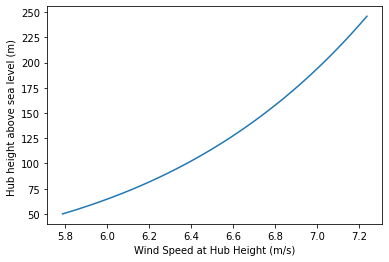

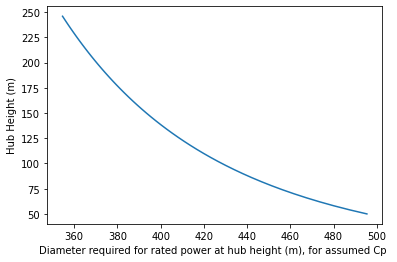

In [11]:
## influence of hub height on diameter for fixed power
cp_assume = 0.46 # assuem a likely Cp max
Prated=10000000.0 # rated power in watts
Pturb=Prated/(0.965*0.985) # power needed
Hi = np.zeros(50)
V = np.zeros(50)
Di = np.zeros(50)

for ic in range(50):
   Hi[ic]=50.0+ic*(250.0-50.0)/50.0
   A=0.14* np.log(Hi[ic]/10.0)
   V[ic] = Uten*np.exp(A)
   Di[ic] = np.sqrt(Pturb/(cp_assume*0.125*Density*np.power(V[ic],3)*np.pi))

plt.figure()
plt.xlabel('Wind Speed at Hub Height (m/s)')
plt.ylabel('Hub height above sea level (m) ')
plt.plot(V,Hi)

plt.figure()
plt.ylabel('Hub Height (m)')
plt.xlabel('Diameter required for rated power at hub height (m), for assumed Cp ')
plt.plot(Di,Hi)

Need to input in the next box the input values for the selected turbine design

In [12]:
print('Current Diameter ',D,' [m]')
print('Number of Blades',Nblades,'')
print('Current tip chord (m)',actual_chord)
print('Current pitch angle[deg]',pitch)
print('Current design [rpm]',RPM)
print('Current Hub Height',HH,' [m]')
print('Current rated speed ',vrated,' m/s')
print('Current clearance', clearance,'[m]')
print('Current Rated Power', Prated/1000000.0,' [MW]')

Current Diameter  362.5  [m]
Number of Blades 3 
Current tip chord (m) 10
Current pitch angle[deg] -1
Current design [rpm] 3.1
Current Hub Height 206.8  [m]
Current rated speed  7.061761459072345  m/s
Current clearance 25.55000000000001 [m]
Current Rated Power 10.0  [MW]


  Wind :   Pitch :  rpm:  TSR:  Cp:  Ct  Power (MW): 
  speed    [deg]          coeff     coeff    [N]     power 
  [m/s]
   0.510  -1.000     3.1  115.325  -0.0000  0.0000  -0.0000
   1.020  -1.000     3.1  57.663  -0.8617  0.0704  -0.0578
   1.531  -1.000     3.1  38.442  -0.3395  0.1788  -0.0768
   2.041  -1.000     3.1  28.831  -0.1155  0.3216  -0.0619
   2.551  -1.000     3.1  23.065  0.0839  0.4033  0.0880
   3.061  -1.000     3.1  19.221  0.1680  0.4535  0.3042
   3.571  -1.000     3.1  16.475  0.2171  0.4995  0.6242
   4.082  -1.000     3.1  14.416  0.2887  0.6498  1.2387
   4.592  -1.000     3.1  12.814  0.3678  0.7684  2.2475
   5.102  -1.000     3.1  11.533  0.4146  0.7791  3.4751
   5.612  -1.000     3.1  10.484  0.4375  0.7695  4.8806
   6.122  -1.000     3.1   9.610  0.4488  0.7535  6.5002
   6.633  -1.000     3.1   8.871  0.4533  0.7357  8.3476
   7.143  -1.000     3.1   8.238  0.4536  0.7190  10.4337
   7.653  -1.000     3.1   7.688  0.4463  0.6949  12.6255
   8.163  -1

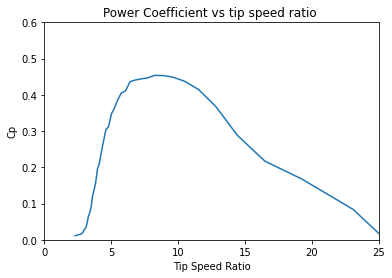

In [13]:
# Calculate non-dimensional turbine performance 
outputString = ''
outputString += '  Wind : '
outputString += '  Pitch :'
outputString += '  rpm:'
outputString += '  TSR: '
outputString += ' Cp: '
outputString += ' Ct '
outputString += ' Power (MW): '
outputString += '\n'
outputString += '  speed    [deg]          coeff     coeff    [N]     power \n'
outputString += '  [m/s]' 
outputString += '\n'

V_min = 0.0 # minimum wind or tide speed
V_max = 25.0 # maximum wind or tide speed
No_Int = 50 # assess performance at tshi number of values
dV=(V_max-V_min)/(No_Int-1)
TSRs=np.zeros(No_Int)
Cps=np.zeros(No_Int)
Cts=np.zeros(No_Int)
Pws=np.zeros(No_Int)
Thr = np.zeros(No_Int)
Vs = np.zeros(No_Int)

for ic in range(No_Int):
    VWIND=V_min+(ic+1)*dV # find each w​for ic in range(No_Int):
    Vs[ic] = VWIND
    
    TSRs[ic],Cts[ic],Cps[ic] = TurbinePerformance(dataBlade,dataAero,pitch*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
    # dimensional power take off values
    FCTOR1=Density*np.pi*D*D*VWIND*VWIND/8.0
    Pws[ic] = Cps[ic]*FCTOR1*VWIND
    Thr[ic] = Cts[ic]*FCTOR1
    # output data
    # outputString += '  Overall performance data\n'
    outputString += '  {:6.3f}'.format(VWIND)
    outputString += '  {:6.3f}'.format(pitch)
    outputString += '  {:6.1f}'.format(RPM)
    outputString += '  {:6.3f}'.format(TSRs[ic])
    outputString += '  {:.4f}'.format(Cps[ic])
    outputString += '  {:.4f}'.format(Cts[ic])
    outputString += '  {:.4f}'.format(Pws[ic]/1000000.0) # units are MW
    outputString += '\n'
 
## now try plotting some stuff
plt.figure()
plt.axis([0, 25.0, 0 , 0.6])
plt.plot(TSRs,Cps)
plt.title('Power Coefficient vs tip speed ratio ')
plt.xlabel('Tip Speed Ratio')
plt.ylabel('Cp')
##
print(outputString) # switched off output
with open(outputFilename,"w") as f:
    f.write(outputString)  

The cell below was used to iteratively find the optimal RPM

In [14]:
TSRU = (np.pi*(RPM/60)*(D))/vrated
print(TSRU)
print(f'Max Cp is: {max(Cps)}')
Cpsint = interp1d(TSRs, Cps)
print(f'Cp at Umean is: {Cpsint(TSRU)}')
TSRsint = interp1d(Cps, TSRs)
TSRmax = TSRsint(max(Cps))
print(TSRmax)
Nnew = (TSRmax*vrated)/(np.pi*D)
print(Nnew*60)

8.332115542116904
Max Cp is: 0.45364880577896627
Cp at Umean is: 0.45359870044706124
8.237517737100235
3.064804473237398


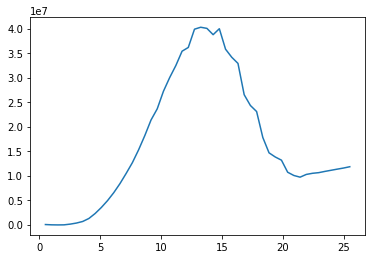

In [15]:
plt.plot(Vs, Pws)
#plt.axis([0, 5, -2 , 10])

# Pitch Angle for Rated Speed
The following is an ammendment to the initial code which iteratively searches for the required pitch angle to achieve rated power above rated speed

In [ ]:
# Calculate non-dimensional turbine performance 
outputString = ''
outputString += '  Wind : '
outputString += '  Pitch :'
outputString += '  rpm:'
outputString += '  TSR: '
outputString += ' Cp: '
outputString += ' Ct '
outputString += ' Power (MW): '
outputString += '\n'
outputString += '  speed    [deg]          coeff     coeff    [N]     power \n'
outputString += '  [m/s]' 
outputString += '\n'

V_min = 0.0 # minimum wind or tide speed
V_max = 20.0 # maximum wind or tide speed
No_Int = 100 # assess performance at tshi number of values
dV=(V_max-V_min)/(No_Int-1)
TSRs=np.zeros(No_Int)
Cps=np.zeros(No_Int)
Cts=np.zeros(No_Int)
Pws=np.zeros(No_Int)
pitchNEW = 0
TSRnew = 0
Ctnew = 0
Cpnew = 0
gen_eff = 0.965
gbox_eff = 0.985

Prated = 10000000 # W
Pturb = Prated/(gen_eff*gbox_eff)
pitches = []
pitches2 = []
Vs = []

for ic in range(No_Int):
    VWIND=V_min+(ic+1)*dV # find each w​for ic in range(No_Int):
   
    TSRs[ic],Cts[ic],Cps[ic] = TurbinePerformance(dataBlade,dataAero,pitch*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
    # dimensional power take off values
    FCTOR1=Density*np.pi*D*D*VWIND*VWIND/8.0
    Pws[ic] = Cps[ic]*FCTOR1*VWIND
    # output data
    # outputString += '  Overall performance data\n'
    outputString += '  {:6.3f}'.format(VWIND)
    outputString += '  {:6.3f}'.format(pitch)
    outputString += '  {:6.1f}'.format(RPM)
    outputString += '  {:6.3f}'.format(TSRs[ic])
    outputString += '  {:.4f}'.format(Cps[ic])
    outputString += '  {:.4f}'.format(Cts[ic])
    outputString += '  {:.4f}'.format(Pws[ic]/1000000.0) # units are MW
    outputString += '\n'
    
    pitchNEW = pitch
    
    
    while Pws[ic] > Pturb:
        pitchNEW = pitchNEW + 0.01
        TSRnew,Cts[ic],Cpnew = TurbinePerformance(dataBlade,dataAero,pitchNEW*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
        Pws[ic] = Cpnew*FCTOR1*VWIND
        
    if Pws[ic]<10400000 and VWIND>7.5:
        pitchint = interp1d(Vs,pitches2,fill_value='extrapolate')
        pitchNEW = pitchint(VWIND)
        TSRnew,Cts[ic],Cpnew = TurbinePerformance(dataBlade,dataAero,pitchNEW*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
        Pws[ic] = Cpnew*FCTOR1*VWIND
        while Pws[ic] < 10400000 or Pws[ic] > 10600000:
            pslim = pitchNEW
            ps = np.arange(0,90,0.001)
            for i in ps:
                pitchNEW = i
                TSRnew,Cts[ic],Cpnew = TurbinePerformance(dataBlade,dataAero,pitchNEW*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
                Pws[ic] = Cpnew*FCTOR1*VWIND
                if Pws[ic] > 10400000 and Pws[ic] < 10600000:
                    break
            '''
            if Pws[ic] < 10400000:
                pitchNEW = pitchNEW - 0.0001
                TSRnew,Ctnew,Cpnew = TurbinePerformance(dataBlade,dataAero,pitchNEW*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
                Pws[ic] = Cpnew*FCTOR1*VWIND
            if Pws[ic] > 10600000:
                pitchNEW = pitchNEW + 0.00011
                TSRnew,Ctnew,Cpnew = TurbinePerformance(dataBlade,dataAero,pitchNEW*np.pi/180.0,ScaleFactor,Nblades,D,VWIND,RPM)
                Pws[ic] = Cpnew*FCTOR1*VWIND
                print(pitchNEW)
                '''
    print(f'Pitch at V = {VWIND} is: {pitchNEW}')
    pitches.append(pitchNEW)
    if VWIND>7.3:
        Vs.append(VWIND)
        pitches2.append(pitchNEW)
        
## now try plotting some stuff
plt.figure()
plt.axis([0, 25.0, 0 , 0.6])
plt.plot(TSRs,Cps)
plt.title('Power Coefficient vs tip speed ratio ')
plt.xlabel('Tip Speed Ratio')
plt.ylabel('Cp')
##
print(outputString) # switched off output
with open(outputFilename,"w") as f:
    f.write(outputString)  

In [ ]:
def Pshift2(V_min, V_max, No_Int, cut_in=2.6, P=Pws, Pturb=Pturb, vrated=vrated):
    dV=(V_max-V_min)/(No_Int-1)
    vc=np.zeros(No_Int)
    Pws_new=np.zeros(No_Int)
    for ic in range(No_Int):
        vc[ic] = V_min+(ic+1)*dV
        if vc[ic]<=cut_in:
            Pws_new[ic]=0
        else:
            Pws_new[ic] = P[ic-1]
        
    return(Pws_new)

powers = Pshift(0,20,100)

The following cell outputs the power profile and pitch profile graph, indicating cut-in, cut-out and rated speed.

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.axvline(x=vrated, color='coral')
ax1.axvline(x=2.6, color='coral')
ax1.axvline(x=20, color='coral')
#ax1.axhline(y=Pturb/1e6)
ax1.plot(V+dV, Pws/1e6, label='Power', color='blue')
ax2.plot(V+dV, pitches, 'g-', label='Pitch angle')

ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Power (MW)', color='blue')
ax2.set_ylabel('Pitch angle (degrees)', color='g')
plt.text(1.5, 28.5, 'Cut-in \nspeed', fontsize=10, bbox=dict(facecolor='red', alpha=0.3))
plt.text(5.9, 28.5, 'Rated \nspeed', fontsize=10, bbox=dict(facecolor='red', alpha=0.3))
plt.text(18.5, 28.5, 'Cut-out \nspeed', fontsize=10, bbox=dict(facecolor='red', alpha=0.3))

plt.title('')




In [ ]:
V = np.linspace(0,20,100)
plt.axis([0, 25.0, 0 , 1.1e7])
plt.plot(V,Pws)
plt.axvline(x=7.061761459072345  )
#print(Pws)

In [ ]:
plt.plot(V,pitches)
plt.axis([2.6, 20.0, -2 , 30])
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Pitch Angle vs Wind Speed between cut-in and cut-out speeds')


In [ ]:
PwrR = []
count = 0
for i in V:
    if i >= vrated and i<=19.7:
        PwrR.append(Pws[count])
    count += 1
#print(PwrR)
std = statistics.stdev(PwrR, Pturb)
print(std)

In [ ]:
# Examine power capture behaviour
# Define Cut in speed
# Define cut out speed
# operational conditions, change these value for tidal turbine and to see how they 

V_cutin = 2.6 # m/s    
V_cutout = 20.0 #m/s

#  generator + gearbox _efficiency
gen_eff = 0.965
gbox_eff = 0.985

# rated power
Prated = 10000000 # W
Pturb = Prated/(gen_eff*gbox_eff)

vc=np.zeros(No_Int)
rc=np.zeros(No_Int)
for ic in range(No_Int):
    vc[ic]=V_min+(ic+1)*dV # find each w for ic in range(No_Int):
    rc[ic]=Rayleigh(vc[ic],vrated)
    if vc[ic] < V_cutin:
        Pws[ic] = 0.0
    elif vc[ic] >= V_cutout:
        Pws[ic] = 0.0
    elif Pws[ic] > Pturb:
        Pws[ic] = Pturb

plt.figure()
plt.axis([0, V_max, 0 , 1.2*Pturb])
plt.plot(vc,Pws)
plt.title('Wind speed vs Regulated Power output ')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('MW')   

plt.figure()
plt.axis([0, V_max, 0 , 0.1])
plt.plot(vc,rc)
plt.title('Wind speed vs Rayleight probability ')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('f(V)')   

The following function alters the power values slightly to ensure below cut-in the power is zero and above rated speed the power is rated power

In [ ]:
def Pshift(V_min, V_max, No_Int, cut_in=2.6, P=Pws, Pturb=Pturb, vrated=vrated):
    dV=(V_max-V_min)/(No_Int-1)
    vc=np.zeros(No_Int)
    Pws_new=np.zeros(No_Int)
    for ic in range(No_Int):
        vc[ic] = V_min+(ic+1)*dV
        if vc[ic]<cut_in:
            Pws_new[ic]=0
        elif vc[ic]>=cut_in and vc[ic]<vrated:
            Pws_new[ic]=P[ic]
        elif vc[ic]>=vrated:
            Pws_new[ic] = Pturb
    return(Pws_new)

The following cell defines the Weibull distribution used for energy capture calculations

In [ ]:
def Weibull(U, Uhat=vrated):
    exp = np.exp(-np.pi*(U/(2*Uhat))**2)
    frac = (np.pi*U)/(2*Uhat**2)
    f = frac*exp
    return(f)

The following cell determines the probability of a wind speed above 20m/s occuring

In [ ]:
V_min = 0.0 # minimum wind or tide speed
V_max = 10000 # maximum wind or tide speed
No_Int = 10000 # assess performance at tshi number of values
dV=(V_max-V_min)/(No_Int-1)
vc=np.zeros(No_Int)
W=np.zeros(No_Int)
cum = 0
for ic in range(No_Int):
    vc[ic]=V_min+(ic+1)*dV # find each w for ic in range(No_Int):
    W[ic]=Weibull(vc[ic],vrated)
    if vc[ic] >=20:
        cum = cum + W[ic]

print(cum*100)

The following cell defines the function used for energy capture calculations using the Weibull distribution

In [ ]:
def EnergyCap(V_max, V_min, Pws=Pws, T=1, No_Int=100, gen_eff=0.965, gbox_eff=0.985):
    P = Pshift(V_min, V_max, No_Int, P=Pws)
    Pcum = 0
    dV=(V_max-V_min)/(No_Int-1)
    vc=np.zeros(No_Int)
    hrs = T*365*24
    for ic in range(No_Int):
        vc[ic]=V_min+(ic+1)*dV
        Pu = (P[ic]*gen_eff*gbox_eff)*Weibull(vc[ic])*dV
        Pcum = Pcum + Pu
    E = hrs*Pcum
    return(E)

In [ ]:
energy = EnergyCap(20, 0, No_Int=100)
print(energy/1e9) # Print the expected energy capture in GWh

The following cell reads the 2019 wind speed data and takes out only the component of wind speed in the downstream direction, with those +/- 90 degrees of the wind turbine orientation being set to 0

In [ ]:
lines = []
windDir = 247.5
upper = windDir + 90
lower = windDir - 90
speeds = []

with open('2019Wind.csv', 'r') as wind:
    lines = wind.readlines()
for line in lines:
    split = line.split(',')
    Uwind = float(split[0])
    Dir = float(split[1])
    if Dir>upper or Dir<lower:
        speeds.append(0)
    else:
        angle = ((Dir-windDir)*np.pi)/180
        speeds.append(Uwind*np.cos(angle))


Computes the speeds at hub height

In [ ]:
speedsHH = []
for speed in speeds:
    speed = speed*np.exp(A)
    speedsHH.append(speed)

The following cell finds the probability of 100 wind speed ranges for the 2019 wind speed data

In [ ]:
hist, bins = np.histogram(speedsHH, bins=100)
hist = hist/np.sum(hist)
bin_width = bins[1]-bins[0]
probs = []
speedsHH = sorted(speedsHH)
for speed in speedsHH:
    bin_idx = int((speed-bins[0])/bin_width)
    prob = hist[bin_idx-1]
    probs.append(prob)

In [ ]:
plt.plot(speedsHH,probs)

A function is defined to determine the probability of a given wind speed occuring within a given wind speed dataset

In [ ]:
def probability(speed, data=speedsHH):
    hist, bins = np.histogram(data, bins=100)
    hist = hist/np.sum(hist)
    bin_width = bins[1]-bins[0]
    bin_idx = int((speed-bins[0])/bin_width)
    prob = hist[bin_idx]
    return(prob)

The following defines a function to determine the energy capture of one turbine using the realistic probability distribution

In [ ]:
def EnergyCap2(V_max, V_min, Pws=Pws, T=1, No_Int=100, gen_eff=0.965, gbox_eff=0.985, data=speedsHH):
    P = Pshift(V_min, V_max, No_Int, P=Pws)
    Pcum = 0
    dV=(V_max-V_min)/(No_Int-1)
    vc=np.zeros(No_Int)
    hrs = T*365*24
    for ic in range(No_Int):
        vc[ic]=V_min+(ic+1)*dV
        Pu = (P[ic]*gen_eff*gbox_eff)*probability(vc[ic],data=data)*dV
        Pcum = Pcum + Pu
    E = hrs*Pcum
    return(E/1e9)

In [ ]:
EnergyCap2(20, 0, No_Int=100)

The Ct distribution against wind speed is determined, and from this a function is defined to determine the wind speed loss due to wake interaction for a given wind speed

In [ ]:
CtInt = interp1d(V,Cts,fill_value='extrapolate')
def deltaV(U):
    speedsNEW = []
    for i in U:
        Ct = np.abs(CtInt(i))
        deltaV = i*(1-np.sqrt(1-Ct))*(1/((1+2*0.04*6))**2)
        speednew = i-deltaV
        speedsNEW.append(speednew)
    return(speedsNEW)
Ctrated = CtInt(vrated)
Thrust = (1/8)*Ctrated*1.223*vrated*vrated*np.pi*D*D
print(Thrust)

The speed datasets are modified for each layer of turbines in the array, i.e. turbines with more turbines in front of them will experience lower wind speeds

In [ ]:
speedsHH2 = deltaV(speedsHH)
speedsHH3 = deltaV(speedsHH2)
speedsHH4 = deltaV(speedsHH3)
speedsHH5 = deltaV(speedsHH4)
speedsHH6 = deltaV(speedsHH5)
speedsHH7 = deltaV(speedsHH6)

The energy capture is determined for turbines at each layer within the array

In [16]:
Energy1 = EnergyCap2(20,0,data=speedsHH)
Energy2 = EnergyCap2(20,0,data=speedsHH2)
Energy3 = EnergyCap2(20,0,data=speedsHH3)
Energy4 = EnergyCap2(20,0,data=speedsHH4)
Energy5 = EnergyCap2(20,0,data=speedsHH5)
Energy6 = EnergyCap2(20,0,data=speedsHH6)
Energy7 = EnergyCap2(20,0,data=speedsHH7)

NameError: name 'EnergyCap2' is not defined

In [ ]:
HHs = np.arange(1,8,1)
energies = [Energy1,Energy2,Energy3,Energy4,Energy5,Energy6,Energy7]
plt.plot(HHs,energies)

The number of turbines at each layer is counted and from this the total energy capture is determined

In [ ]:
block0=22
block1=21
block2=20
block3=18
block4=18
block5=11
block6=0
energytot = block0*Energy1+block1*Energy2+block2*Energy3+block3*Energy4+block4*Energy5+block5*Energy6
print(f'The total energy of the array over one year is: {energytot} GWh')

The following cell was used to find the LCOE

In [ ]:
years = 27
ran = np.arange(-5,years+2,1)
r=0.06
DevCost = 120000*1100
PlantCost = 600000*1100
InstCost = 650000*1100
OMCost = 75000*1100
DecommCost = 310000*1100
towercost = 1240000*110
othercost = 100000
E=energytot*1000
cumcost = 0
cumE = 0
for year in ran:
    if year == 1:
        I = towercost  + DevCost + PlantCost + InstCost
    elif year == max(ran):
        I = DecommCost
    else:
        I = 0
    Mcost = OMCost
    comp = (1+r)**year
    cumcost = ((I+Mcost)/comp) + cumcost
    cumE = E/comp + cumE

LCOE = cumcost/cumE

In [ ]:
print(LCOE)